### Differential abundance analyses

#### 1. Load required libraries

In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("apeglm")
# install.packages("pheatmap")
library(pheatmap, warn.conflicts = F, quietly = T)
library(ggplot2, warn.conflicts = F, quietly = T)
library(limma, warn.conflicts = F, quietly = T)
library(DESeq2, warn.conflicts = F, quietly = T)
library(edgeR, warn.conflicts = F, quietly = T)
library(Glimma, warn.conflicts = F, quietly = T)
library(apeglm, warn.conflicts = F, quietly = T)

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”

Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:


#### 2. Load data

In [2]:
metadata <- read.table("../03-diff_abundance/map.txt", header=T, sep="\t")
row.names(metadata) <- metadata$sample_id
genecounts <- read.delim("read_counts_goKegg.txt", header=T, sep="\t", row.names = 1)
# fix sample names gene count file
colnames(genecounts) <- gsub(x = names(genecounts), pattern = "X", replacement = "UF")  

In [3]:
# remove rows with empty values
genecounts <- genecounts[!(is.na(genecounts$KEGG) | genecounts$KEGG==""),]

#### 3. Group by KEGG and GO terms (two different R objects)

In [4]:
library(tidyverse)
gogroup <- aggregate(genecounts[, 16:86], by=list(genecounts$GO_ID), FUN=sum)
kegggroup <- aggregate(genecounts[, 16:86], by=list(genecounts$KEGG), FUN=sum)
gogroup <- gogroup %>% remove_rownames %>% column_to_rownames("Group.1")
kegggroup <- kegggroup %>% remove_rownames %>% column_to_rownames("Group.1")

head(gogroup)
head(kegggroup)

── Attaching packages ──────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

Warning message:
“package ‘tibble’ was built under R version 4.1.3”
── Conflicts ─────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()        masks IRanges::collapse()
✖ dplyr::combine()         masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()           masks matrixStats::count()
✖ dplyr::desc()            masks IRanges::desc()
✖ tidyr::expand()          masks S4Vectors::expand()
✖ dplyr::filter()          masks stats::filter()
✖ dplyr::first()           masks S4Vectors::first()
✖ dplyr::lag()             masks stats::lag()
✖ BiocGenerics::Position() masks ggplot2::Position(), base::Position()
✖ purrr::reduce()          masks GenomicRanges::reduce(), IRanges::reduce()
✖ dplyr::rename()          masks S4Vectors::rename()
✖ dplyr::slice()           masks IRanges::slice()



,UF102PFR,UF106PFR,UF10PD,UF115PD,UF12PD,UF13PF,UF14PF,UF15PD,UF17PF,UF20PD,⋯,UF6PF,UF70PF,UF73PF,UF76PDR,UF77PF,UF79PF,UF7PF,UF82PFR,UF87PFR,UF8PF
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GO:0000006,448,952,4052,4035,2722,1560,2853,975,1398,318,⋯,3124,1697,1210,2902,1052,2111,3365,3520,3110,4665
GO:0000014,773,583,5849,2798,9237,2839,3488,1598,662,992,⋯,2740,699,1547,5195,1198,2121,8191,1211,1297,3700
GO:0000015,5200,13225,4837,9935,791,153,12588,4330,14105,9,⋯,1636,1954,873,28,8206,3773,3203,8804,34742,12815
GO:0000018,573,717,1713,1616,1385,1007,2544,557,2091,239,⋯,1887,758,798,1475,829,2586,3268,760,2301,2598
GO:0000023,0,12,1105,94,3,1828,31,80,5,3,⋯,0,25,65,266,19,254,74,22,1,27
GO:0000025,927,206,11,26,64,0,28,2,55,0,⋯,80,19,198,0,288,560,250,278,517,127


,UF102PFR,UF106PFR,UF10PD,UF115PD,UF12PD,UF13PF,UF14PF,UF15PD,UF17PF,UF20PD,⋯,UF6PF,UF70PF,UF73PF,UF76PDR,UF77PF,UF79PF,UF7PF,UF82PFR,UF87PFR,UF8PF
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
K00005,134,742,3569,365,1003,185,286,109,26,514,⋯,7,163,468,1170,74,224,473,339,156,235
K00009,7,84,379,48,290,116,230,82,4,101,⋯,0,24,66,1445,8,48,296,41,7,55
K00012,214,100,3838,784,3343,1195,650,314,353,698,⋯,65,553,242,3832,143,914,1597,459,375,584
K00013,3,6,27,3,23,0,4,5,1,3,⋯,0,1,6,50,0,25,124,9,0,7
K00014,374,191,8,21,135,13,496,91,113,0,⋯,306,54,148,0,406,249,366,241,602,415
K00024,1920,5247,1236,2379,382,70,3162,1506,4704,1,⋯,889,362,156,4,3253,1275,916,1958,11822,4496


#### 4. Format for DESeq2 analysis (GO terms)

In [5]:
# only compare PD to PF
metadata <- metadata[metadata$tooth_type != "PE",]
# only keep columns found in metadata
gogroup <- gogroup[, colnames(gogroup) %in% row.names(metadata)]
# reorder by metadata rownames
metadata <- metadata[colnames(gogroup),]
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = gogroup, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PF"))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 369 60 
metadata(1): version
assays(1): counts
rownames(369): GO:0000006 GO:0000014 ... GO:0030246 GO:0042597
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(10): sample_id tooth_type ... ads_nmol_min_mg_of_protein
  concentration_ng_ul

#### 4. Run DESeq2

In [6]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm 
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function

norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 13 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



   user  system elapsed 
  9.966   0.436   7.109 

In [7]:
# save.image()
res <- results(se_star, alpha=0.05)
# order by p value
res <- res[order(res$padj),]
paste("number of GO terms with adjusted p value lower than 0.05: ", sum(res$padj < 0.05, na.rm=TRUE))
summary(res)

[1] "number of GO terms with adjusted p value lower than 0.05:  219"


out of 369 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 108, 29%
LFC < 0 (down)     : 111, 30%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [8]:
resultsNames(se_star)

[1] "Intercept"           "tooth_type_PF_vs_PD"

In [9]:
# filter out low count genes
resLFC <- lfcShrink(se_star, coef="tooth_type_PF_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of go Terms with adjusted p value lower than 0.05: ", sum(resLFC$padj < 0.05, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results_GO.txt", quote=F, sep="\t")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of go Terms with adjusted p value lower than 0.05:  219"


out of 369 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 116, 31%
LFC < 0 (down)     : 120, 33%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



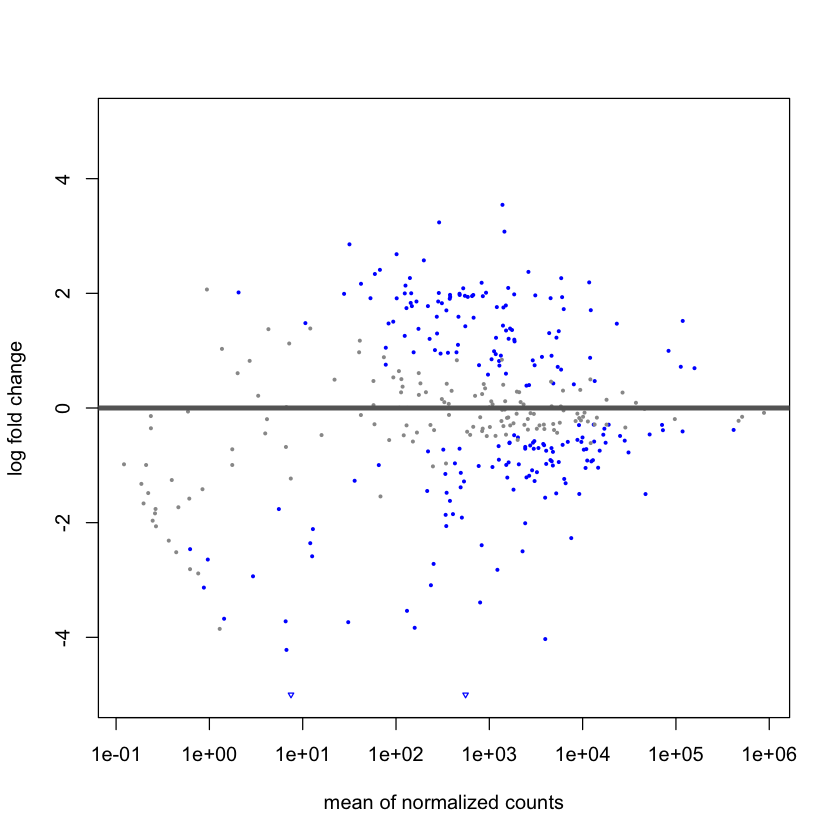

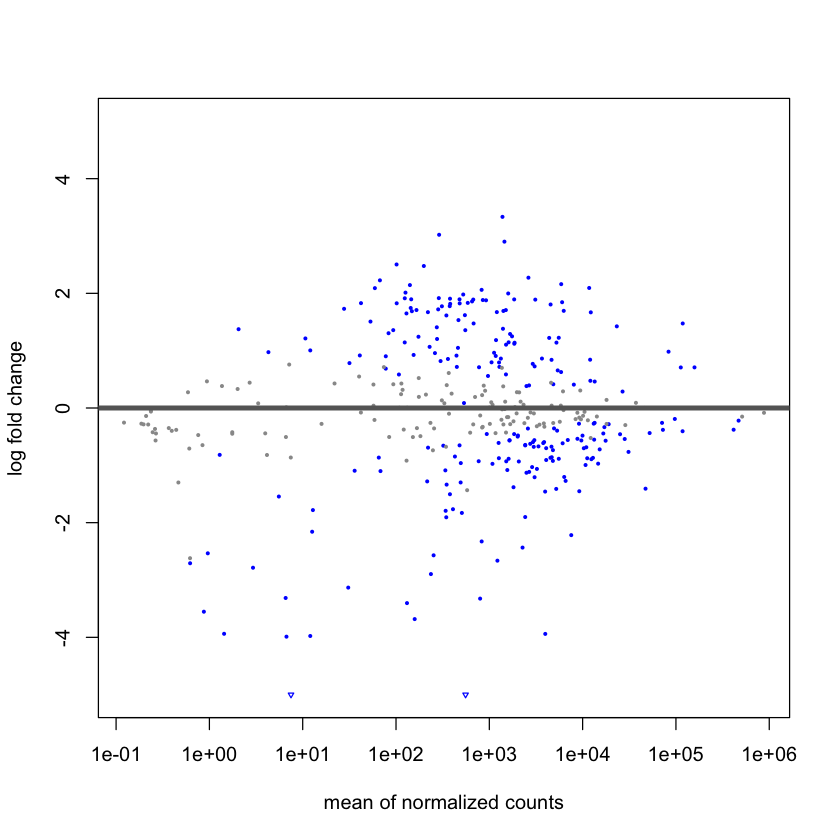

In [10]:
volcano_all <- plotMA(res, ylim=c(-5,5))
plotMA(res, ylim=c(-5,5))
volcano_flat <- plotMA(resLFC, ylim=c(-5,5))
plotMA(resLFC, ylim=c(-5,5))

In [11]:
# transform for visualizations
sub <- nrow(se_star)
se_star
vld <- varianceStabilizingTransformation(se_star)

class: DESeqDataSet 
dim: 369 60 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(369): GO:0000006 GO:0000014 ... GO:0030246 GO:0042597
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(12): sample_id tooth_type ... sizeFactor replaceable

pdf 
  2

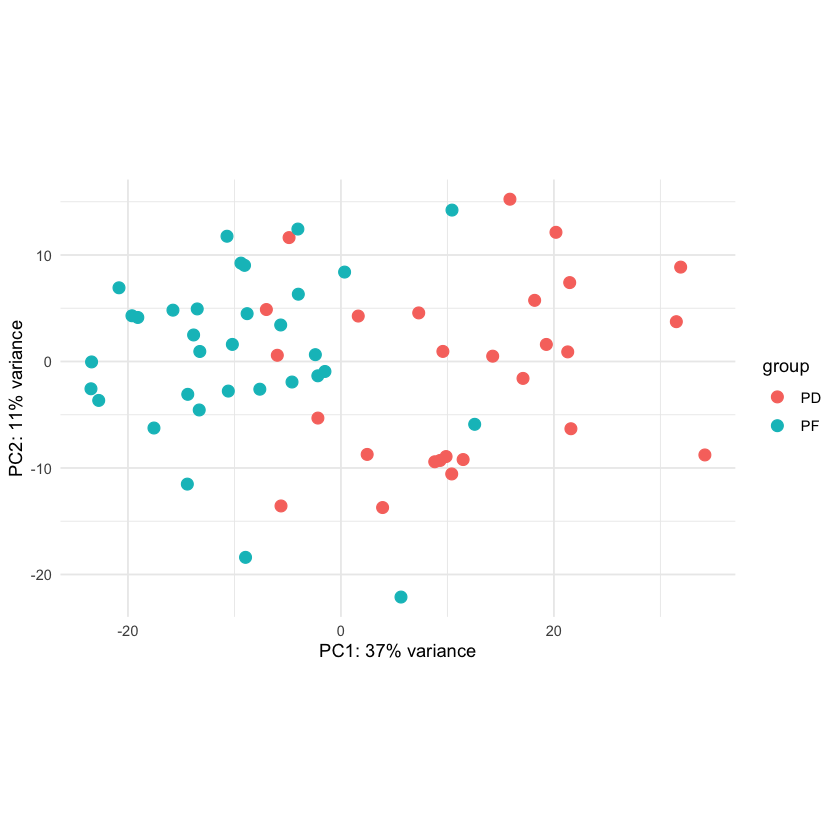

In [12]:
#Get 500 top varying GO terms
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 500)

#make a subset of the log transformed counts for just the top 25 varying GO terms
top500Counts <- assay(vld)[topVarGenes,]
write.csv(top500Counts, file="top500counts.GO.csv", quote=FALSE)
 
#PLOT PCA
#PCA using top 500 varying genes
pdf("pca_pdvpf_GO.pdf")
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()

pdf 
  2

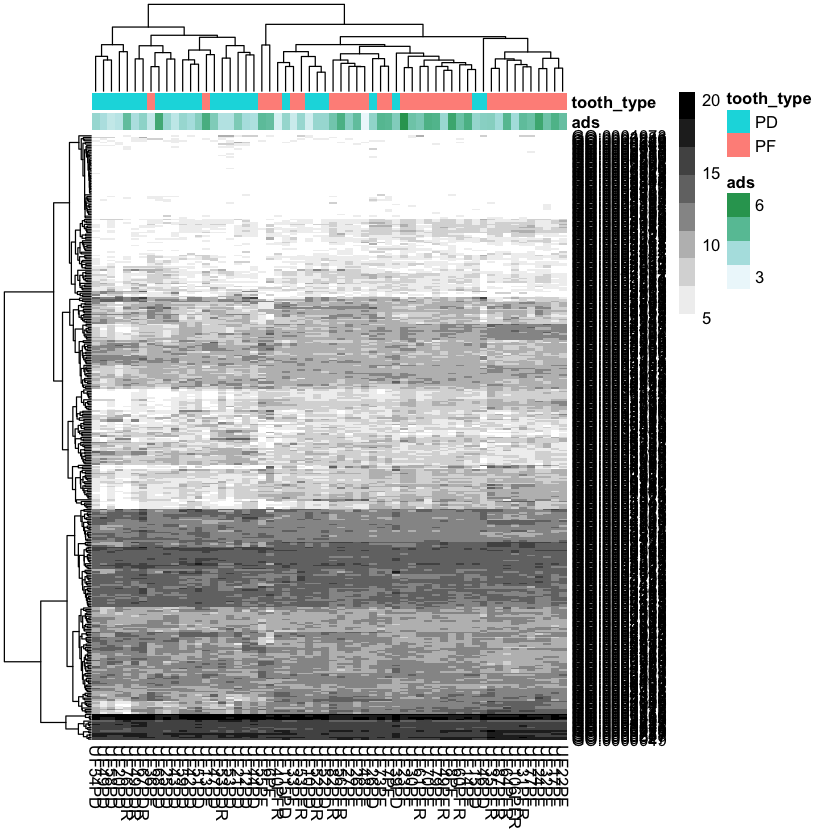

In [13]:
# get heatmap of top 25 
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 25)

#make a subset of the log transformed counts for just the top 25 varying KEGG terms
top25Counts <- assay(vld)[topVarGenes,]
write.csv(top25Counts, file="top25counts.GO.csv", quote=FALSE)

df <- as.data.frame(colData(vld)[,c("ads_nmol_min_mg_of_protein","tooth_type")])
df$ads_nmol_min_mg_of_protein <- log2(as.numeric(df$ads_nmol_min_mg_of_protein))
colnames(df) <- c("ads", "tooth_type")

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
library(RColorBrewer)
x <- pheatmap(top500Counts, annotation_col = df, color = brewer.pal(9, "Greys"))
save_pheatmap_pdf(x, "heatmap_pdvpf.GO.pdf")

In [14]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("GO.db")
library(GO.db)
vals <- select(GO.db, keys(GO.db, "GOID"), c("TERM", "ONTOLOGY"))
rownames(vals) <- vals$GOID
head(vals)

Bioconductor version '3.14' is out-of-date; the current release version '3.15'
  is available with R version '4.2'; see https://bioconductor.org/install

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.18), R 4.1.2 (2021-11-01)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'GO.db'”
Old packages: 'AnnotationDbi', 'bslib', 'devtools', 'fontawesome',
  'GenomeInfoDb', 'htmltools', 'igraph', 'limma', 'locfit', 'MASS', 'nlme',
  'pillar', 'pkgload', 'RcppArmadillo', 'RCurl', 'roxygen2', 'RSQLite',
  'S4Vectors', 'sass', 'seriation', 'shiny', 'stringi', 'tibble', 'tidyverse',
  'XML'

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select




'select()' returned 1:1 mapping between

,GOID,TERM,ONTOLOGY
,<chr>,<chr>,<chr>
GO:0000001,GO:0000001,mitochondrion inheritance,BP
GO:0000002,GO:0000002,mitochondrial genome maintenance,BP
GO:0000003,GO:0000003,reproduction,BP
GO:0000006,GO:0000006,high-affinity zinc transmembrane transporter activity,MF
GO:0000007,GO:0000007,low-affinity zinc ion transmembrane transporter activity,MF
GO:0000009,GO:0000009,"alpha-1,6-mannosyltransferase activity",MF


In [15]:

assay(vld)



,UF106PFR,UF10PD,UF115PD,UF12PD,UF13PF,UF14PF,UF15PD,UF17PF,UF20PD,UF21PD,⋯,UF6PF,UF70PF,UF73PF,UF76PDR,UF77PF,UF79PF,UF7PF,UF82PFR,UF87PFR,UF8PF
GO:0000006,10.411479,10.976874,11.639540,11.019238,10.625010,10.360894,10.428827,10.508413,9.756698,10.796605,⋯,11.510894,11.393372,10.470293,11.124746,10.463773,10.706753,10.927076,11.868502,10.870733,11.128169
GO:0000014,9.717529,11.501944,11.115434,12.771965,11.480447,10.646752,11.133300,9.452062,11.374832,6.946024,⋯,11.323086,10.129227,10.820250,11.958998,10.648735,10.713488,12.201585,10.344015,9.630661,10.797234
GO:0000015,14.187477,11.229986,12.934000,9.270255,7.432413,12.485017,12.563114,13.824889,5.387600,11.838915,⋯,10.586793,11.595378,10.007278,5.290134,13.409062,11.536778,10.856655,13.186350,14.338051,12.577671
GO:0000018,10.009513,9.754453,10.333101,10.058019,10.003669,10.198213,9.636918,11.082552,9.355762,9.955176,⋯,10.790177,10.244099,9.880350,10.161056,10.125647,10.996320,10.885325,9.685163,10.441574,10.294078
GO:0000023,5.100820,9.140376,6.541947,4.027082,10.851005,4.961845,7.034375,4.356449,4.589710,3.354238,⋯,3.354238,5.857400,6.561616,7.799533,5.431910,7.772250,5.933356,5.362957,3.701545,4.896145
GO:0000025,8.278073,4.382251,5.253124,6.070746,3.354238,4.888964,4.098926,6.239812,3.354238,6.607736,⋯,6.547566,5.590088,7.959068,3.354238,8.648304,8.839748,7.348288,8.293775,8.357641,6.313190
GO:0000027,18.016688,16.491193,17.610148,16.708827,16.518762,17.044476,16.994409,17.362852,16.569362,17.129945,⋯,16.907698,17.156241,16.891685,16.025827,18.468172,17.019991,16.626822,17.104286,18.484123,17.304636
GO:0000028,18.153722,15.331571,18.115252,14.779181,14.873266,16.794296,16.244810,17.220931,14.176176,16.024341,⋯,15.857417,16.615513,15.905613,14.388892,18.230733,16.283898,16.182040,16.847920,18.574298,17.022326
GO:0000030,5.747864,7.669513,5.915491,6.197460,10.291699,7.440341,4.617679,6.591260,5.176149,8.729505,⋯,3.354238,6.272487,6.049926,6.881653,5.565348,6.986056,6.220888,7.469851,7.820446,6.640269
GO:0000034,5.666956,6.936661,4.581411,5.188217,5.235012,5.801918,6.938690,3.354238,4.589710,4.127096,⋯,3.354238,3.354238,4.678908,5.609024,4.080414,5.724805,5.164234,4.462609,3.354238,4.664633


In [16]:
#Get 25 top varying GO terms
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 25)

#make a subset of the log transformed counts for just the top 25 varying GO terms
top25Counts <- assay(vld)[topVarGenes,]
head(top25Counts)

,UF106PFR,UF10PD,UF115PD,UF12PD,UF13PF,UF14PF,UF15PD,UF17PF,UF20PD,UF21PD,⋯,UF6PF,UF70PF,UF73PF,UF76PDR,UF77PF,UF79PF,UF7PF,UF82PFR,UF87PFR,UF8PF
GO:0004365,12.513984,4.426007,9.963559,3.354238,4.343170,10.553119,7.557945,6.994411,5.999506,5.547529,⋯,13.599704,7.556269,9.007984,3.354238,12.210612,8.578443,7.738006,12.962522,12.447192,11.111525
GO:0004047,13.165462,6.002675,5.284744,8.643686,5.768389,11.163020,10.358625,10.929850,3.354238,8.986301,⋯,5.090910,5.638526,11.879581,3.354238,13.208913,11.294634,9.203095,12.144433,12.479445,10.523424
GO:0004450,11.276671,7.889605,7.435017,5.985196,7.844505,8.246640,8.351243,9.768202,3.354238,3.354238,⋯,5.361014,9.684060,5.400698,3.354238,11.692424,8.814897,6.577550,9.332393,9.621963,9.441717
GO:0001530,11.451644,10.478317,7.868495,4.764174,4.433547,10.730444,10.394899,7.190831,4.081801,5.277869,⋯,9.129627,6.080524,9.565254,5.196173,10.490556,10.292833,7.831826,11.590166,9.193346,11.097507
GO:0002058,10.840844,11.804025,6.704573,13.562939,9.754401,9.249942,11.590300,7.345292,13.942515,9.795986,⋯,4.798353,9.653383,10.399231,12.145595,8.070390,7.970052,9.508908,10.644626,5.945653,8.206384
GO:0008903,5.488619,9.893147,6.715503,12.061391,6.229156,6.698375,9.127517,4.356449,10.613277,6.538637,⋯,4.098539,6.518453,6.561616,10.720291,3.354238,6.688154,7.966954,5.546583,3.701545,3.971649


In [17]:
gofunc <- merge(vals, top25Counts, by="row.names")
write.table(gofunc, file="deseq_results_GO_FUNC.txt", quote=F, sep="\t")

Get average for PF and PD groups in excel, reload dataset and generate donut plots of functional groups

In [18]:
medGO <- read.delim("deseq_results_GO_FUNC_median_for_R.txt", header=T, row.names=1)
head(medGO)
dim(medGO)

,TERM,ONTOLOGY,PD_MEAN,PF_MEAN,PD_STD,PF_STD
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GO:0000015,phosphopyruvate hydratase complex,CC,10.081188,12.432374,2.407022,1.546434
GO:0000023,maltose metabolic process,BP,6.957630,6.029203,2.517775,1.702747
GO:0000050,urea cycle,BP,8.602579,11.113099,2.133250,1.009988
GO:0000303,response to superoxide,BP,6.020406,7.906571,1.772956,1.702526
GO:0000786,nucleosome,CC,7.276877,9.873525,1.944140,1.365196
GO:0000902,cell morphogenesis,BP,6.703356,8.638603,1.929275,1.741763


[1] 25  6

In [19]:
# install.packages("webr")

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


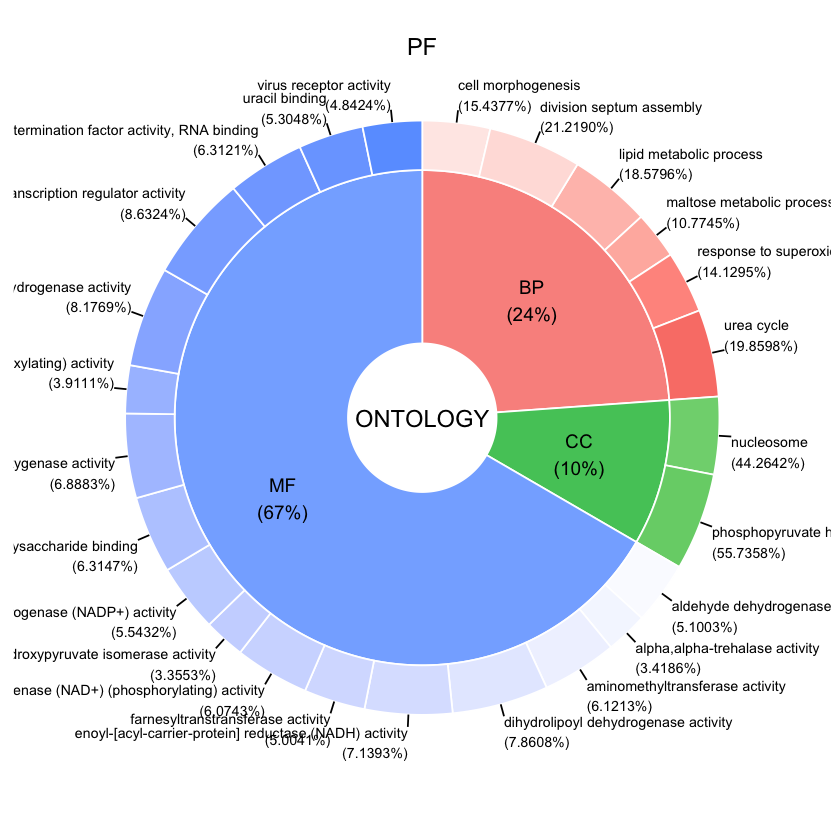

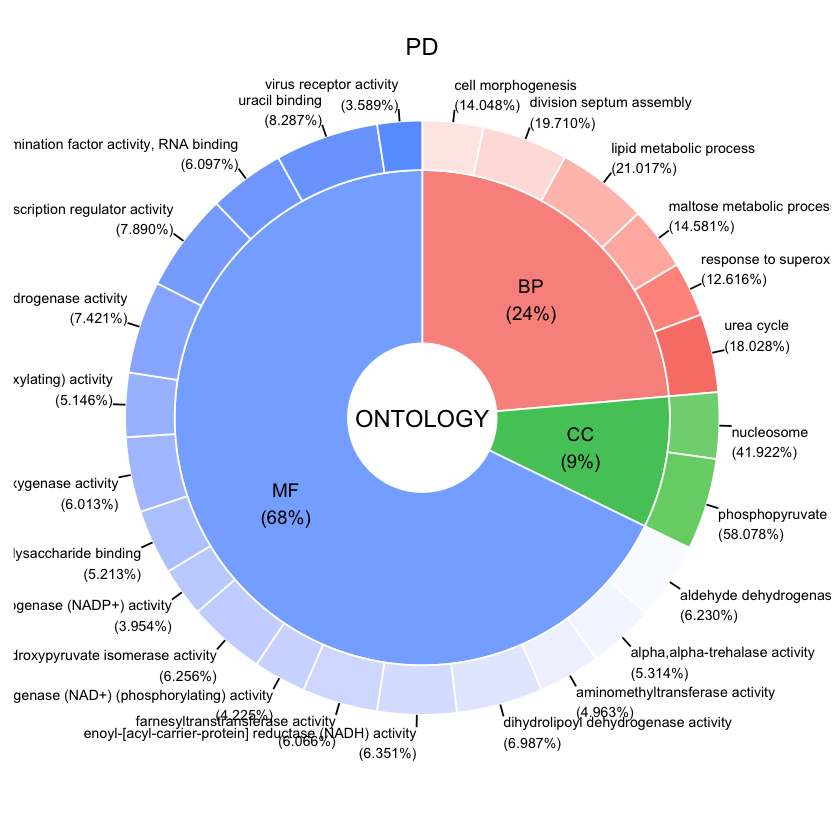

In [20]:
library(webr)
PieDonut(medGO, aes("ONTOLOGY", "TERM", count="PF_MEAN"), title = "PF")
PieDonut(medGO, aes("ONTOLOGY", "TERM", count="PD_MEAN"), title = "PD")

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


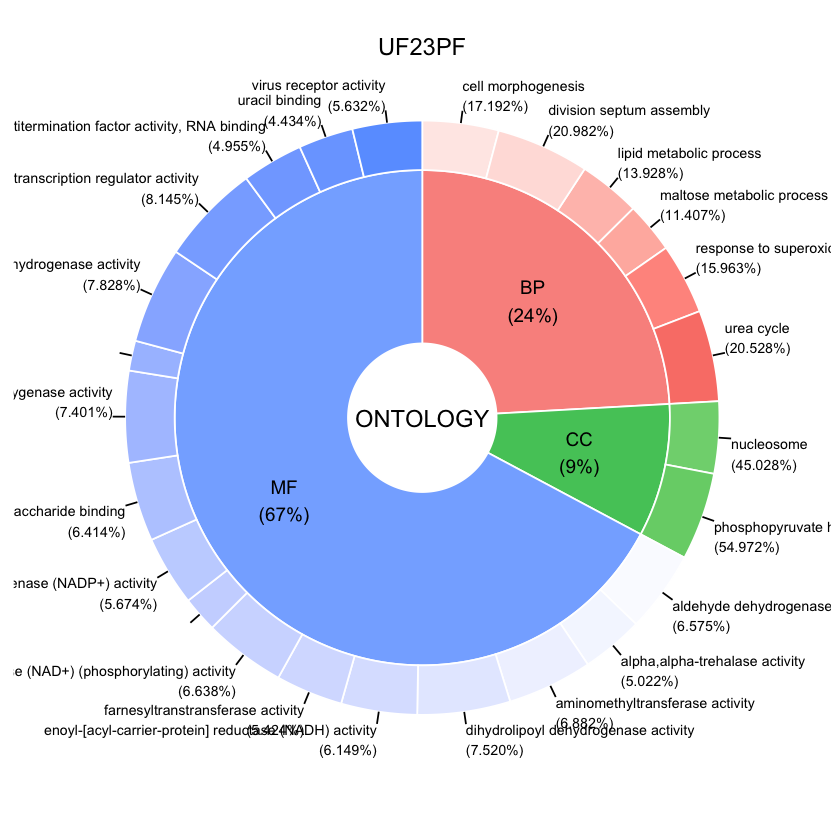

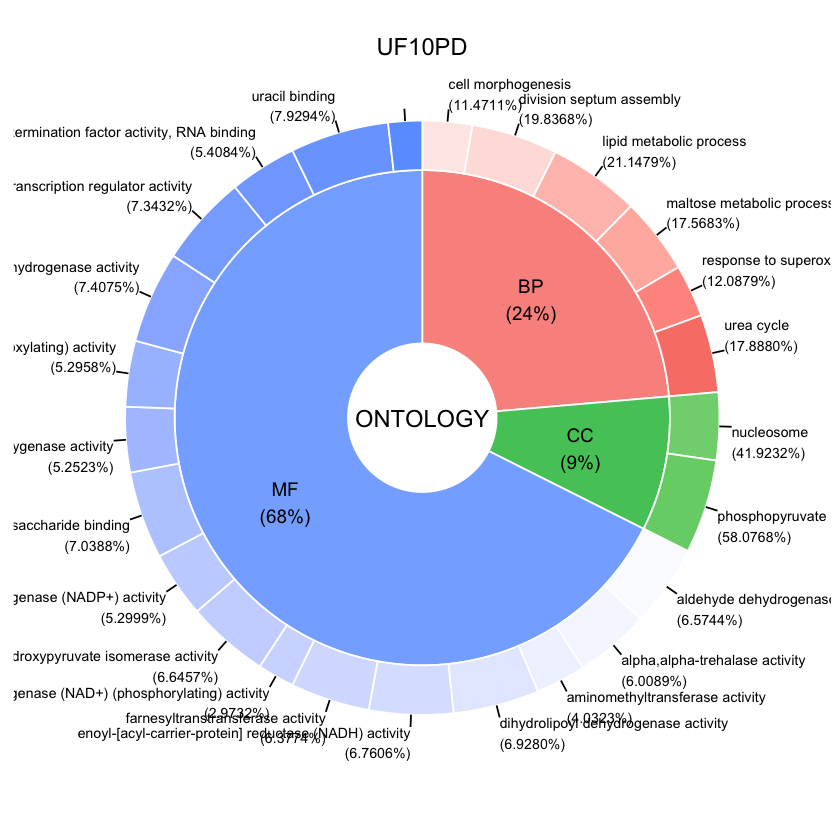

In [21]:
# what about the top and bottom samples in terms of ads nmol mg of protein
PieDonut(gofunc, aes("ONTOLOGY", "TERM", count="UF23PF"), title = "UF23PF")
PieDonut(gofunc, aes("ONTOLOGY", "TERM", count="UF10PD"), title = "UF10PD")


pdf 
  2

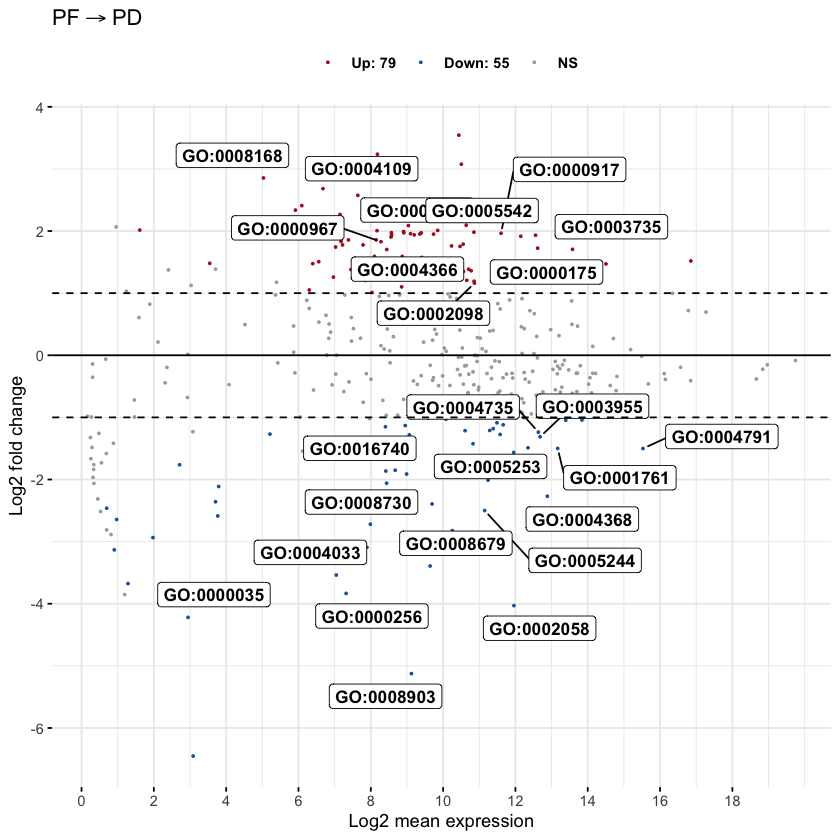

In [22]:
# install.packages("ggpubr")
library(ggpubr)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 2, size = 0.4,
   palette = c("#B31B21", "#1465AC", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 25,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   ggtheme = ggplot2::theme_minimal())
p
pdf("go_volcano_logfold.plot.pdf")
p
dev.off()

#### 5. DeSeq2 with KEGG terms

In [23]:
metadata <- read.table("../03-diff_abundance/map.txt", header=T, sep="\t")
metadata <- metadata[metadata$tooth_type != "PE",]
rownames(metadata) <- metadata$sample_id
# only keep columns found in metadata
kegggroup <- kegggroup[, colnames(kegggroup) %in% rownames(metadata)]
# reorder by metadata rownames
metadata <- metadata[colnames(kegggroup),]
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = kegggroup, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PF"))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 2050 60 
metadata(1): version
assays(1): counts
rownames(2050): K00005 K00009 ... K22719 K22900
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(10): sample_id tooth_type ... ads_nmol_min_mg_of_protein
  concentration_ng_ul

In [24]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm 
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function

norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 86 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



   user  system elapsed 
 12.956   0.593   9.994 

In [25]:
# save.image()
res <- results(se_star, alpha=0.05)
# order by p value
res <- res[order(res$padj),]
paste("number of KEGG terms with adjusted p value lower than 0.05: ", sum(res$padj < 0.01, na.rm=TRUE))
summary(res)

[1] "number of KEGG terms with adjusted p value lower than 0.05:  1210"


out of 2047 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 671, 33%
LFC < 0 (down)     : 720, 35%
outliers [1]       : 0, 0%
low counts [2]     : 3, 0.15%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [26]:
# filter out low count genes
resLFC <- lfcShrink(se_star, coef="tooth_type_PF_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of go Terms with adjusted p value lower than 0.05: ", sum(resLFC$padj < 0.05, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results_KEGG.txt", quote=F, sep="\t")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of go Terms with adjusted p value lower than 0.05:  1391"


out of 2047 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 701, 34%
LFC < 0 (down)     : 759, 37%
outliers [1]       : 0, 0%
low counts [2]     : 3, 0.15%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



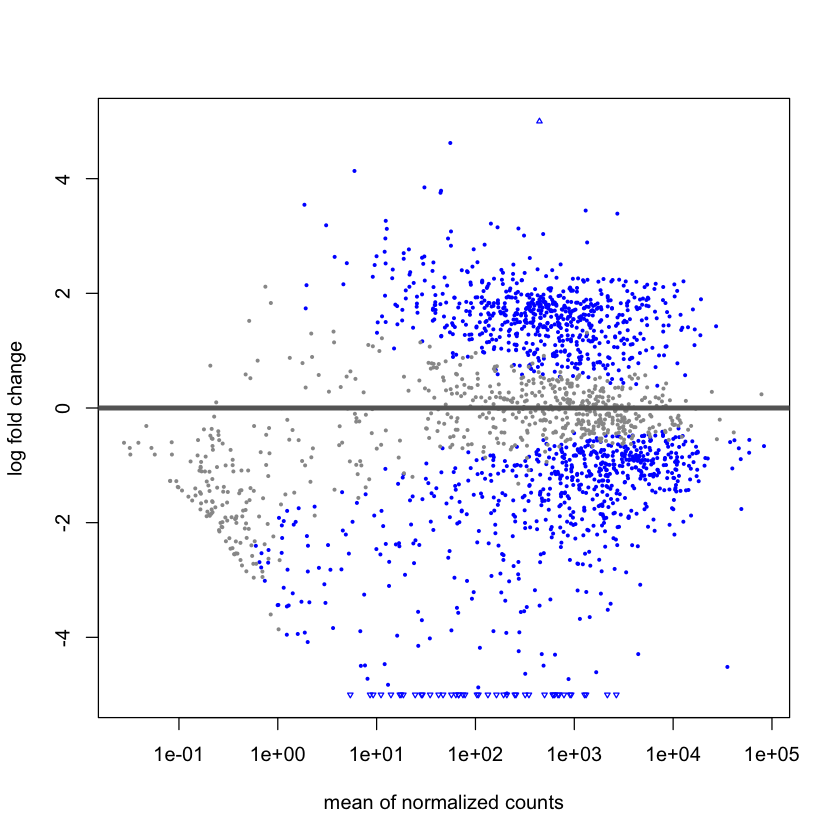

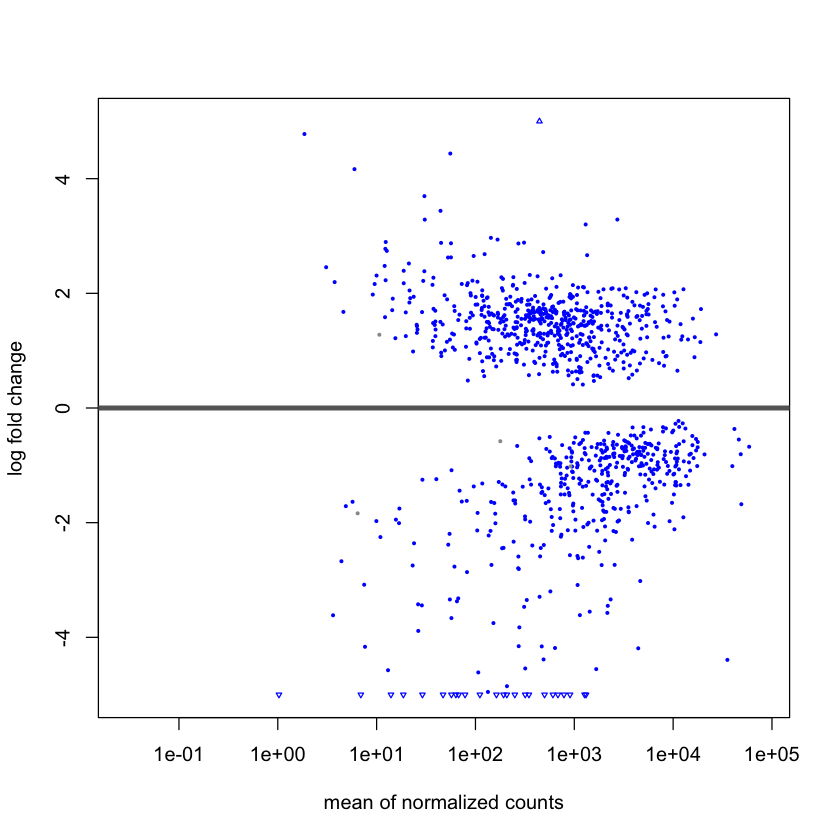

In [27]:
volcano_all <- plotMA(res, ylim=c(-5,5))
plotMA(res, ylim=c(-5,5))
volcano_flat <- plotMA(resLFC, ylim=c(-5,5))
plotMA(resLFC, ylim=c(-5,5))

Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


pdf 
  2

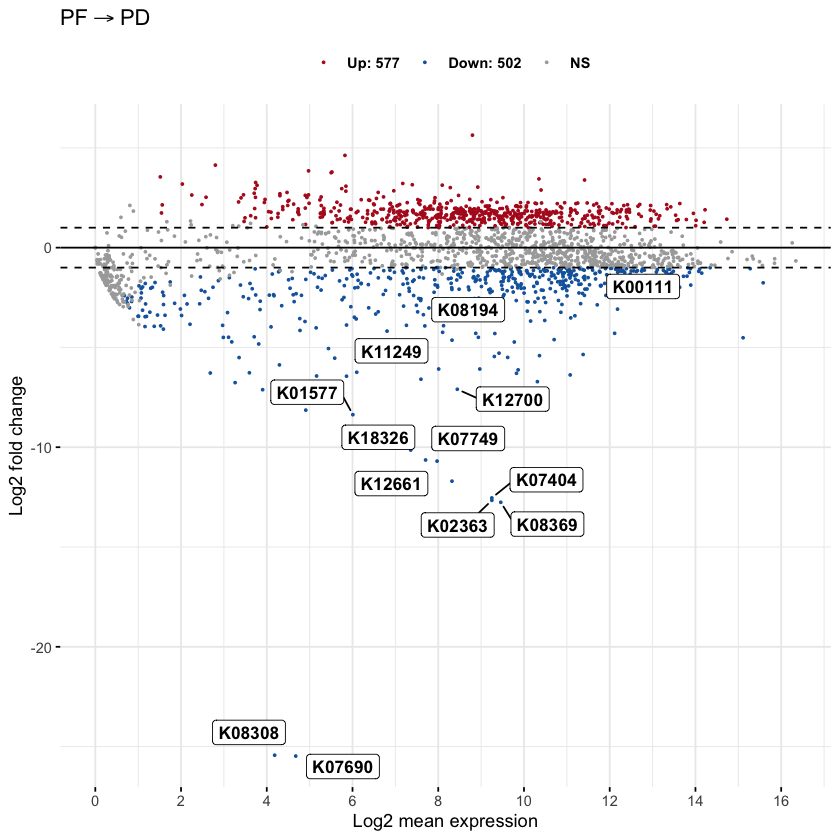

In [28]:
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 2, size = 0.4,
   palette = c("#B31B21", "#1465AC", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 25,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   ggtheme = ggplot2::theme_minimal())
p
pdf("kegg_volcano_logfold.plot.pdf")
p
dev.off()

In [29]:
# transform for visualizations
sub <- nrow(se_star)
se_star
vld <- varianceStabilizingTransformation(se_star)

class: DESeqDataSet 
dim: 2050 60 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(2050): K00005 K00009 ... K22719 K22900
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(12): sample_id tooth_type ... sizeFactor replaceable

pdf 
  2

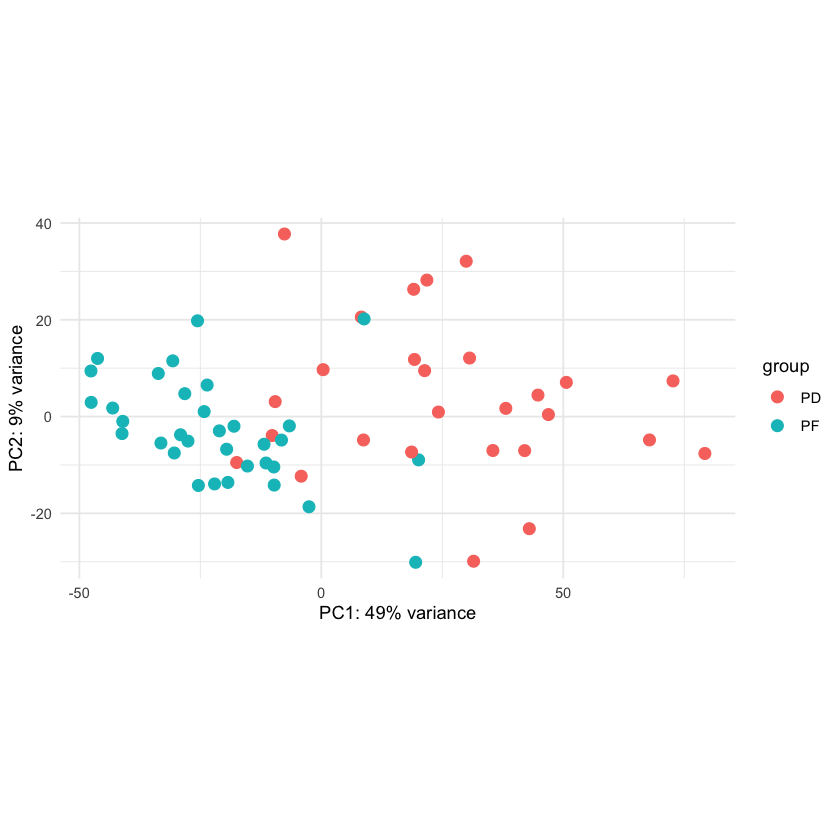

In [30]:
#Get 500 top varying KEGG terms
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 500)

#make a subset of the log transformed counts for just the top 500 varying KEGG terms
top500Counts <- assay(vld)[topVarGenes,]
write.csv(top500Counts, file="top500counts.KEGG.csv", quote=FALSE)

#PLOT PCA
#PCA using top 500 varying genes
pdf("pca_pdvpf_KEGG.pdf")
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()

pdf 
  2

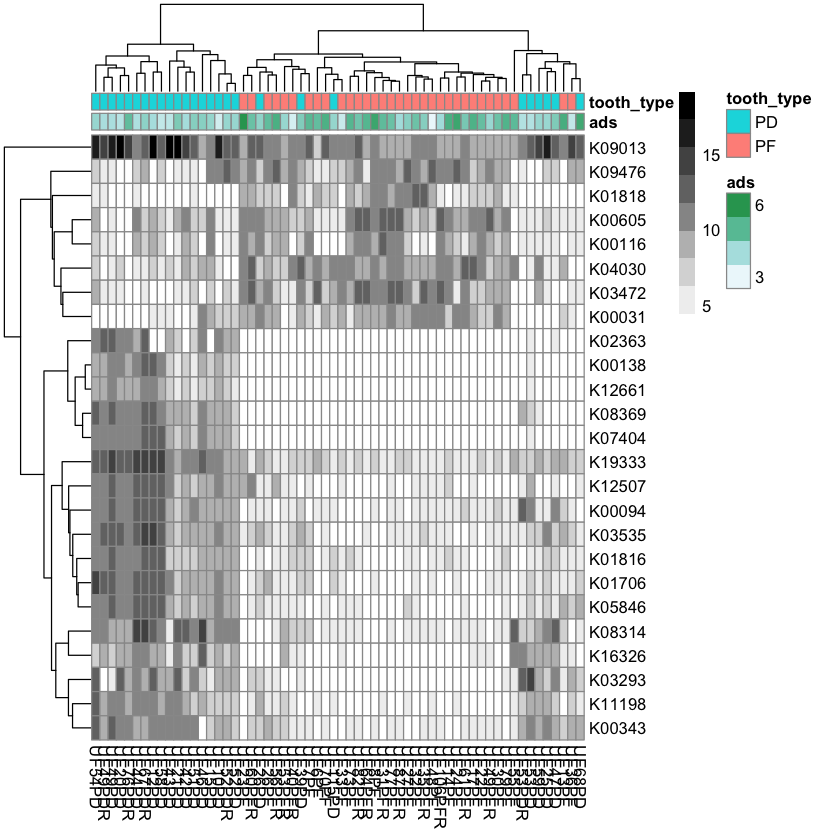

In [31]:
# get heatmap of top 25 
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 25)

#make a subset of the log transformed counts for just the top 25 varying KEGG terms
top25Counts <- assay(vld)[topVarGenes,]
write.csv(top25Counts, file="top25counts.KEGG.csv", quote=FALSE)

df <- as.data.frame(colData(vld)[,c("ads_nmol_min_mg_of_protein","tooth_type")])
df$ads_nmol_min_mg_of_protein <- log2(as.numeric(df$ads_nmol_min_mg_of_protein))
colnames(df) <- c("ads", "tooth_type")

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
library(RColorBrewer)
x <- pheatmap(top25Counts, annotation_col = df, color = brewer.pal(9, "Greys"))
save_pheatmap_pdf(x, "heatmap_pdvpf.KEGG.pdf")